In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
allow_train = False
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 3
BATCH_SIZE = 16
shrink_size = 400

lr = 3e-4
weight_deacay = 0
T_max = 70
eta_min = 1e-7
num_augs = 5
p_dropout = 0.3

crop_size = 284

# weights for alpha is inverse frequency

# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
alpha = torch.tensor([1, 1, 1, 1, 1])
gamma = 2
label_smoothing = 0.1

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [5]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131651..2.2489083].


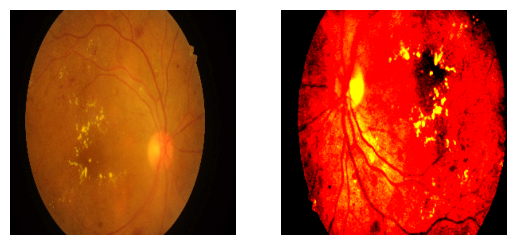

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        for module in model.dense1:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

        for module in model.classification_head:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

x in model before relue is:  tensor([[0.0000, 0.5700, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0122, 1.1229, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7181, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1560, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0081, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5033, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                   [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                        [32, 3, 240, 240]    [32, 2048, 8, 8]     --                   True
│    └─Conv2d (0)                             [32, 3, 240, 240]    [32, 64, 120, 120]   9,408                True
│    └─BatchNorm2d (1)                        [32, 64, 120, 120]   [32, 64, 120, 120]   128                  True
│    └─ReLU (2)                               [32, 64, 120, 120]   [32, 64, 120, 120]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 120, 120]   [32, 64, 60, 60]     --                   --
│    └─Sequential (4)                         [32, 64, 60, 60]     [32, 256, 60, 60]    --                   True
│    │    └─Bottleneck (0)                    [32, 64, 60, 60]     [32, 256, 60, 60]   

Custom Focal Loss function

In [10]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, label_smoothing=0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha.to(device)
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [12]:
# Define loss and optimizer

# from going_modular.focal_loss import FocalLoss

# weights are selected based on the APTOS 2019 distribution according to the paper
# weight = torch.tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weight = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 

# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weight).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
loss_fn_classification = FocalLoss(alpha=alpha, gamma=gamma, label_smoothing=label_smoothing).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)

# scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [13]:
# model = torch.compile(model)

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results

    prepare_model() # restet model's weights to pre train for each fold

    print('\nFirst the encoder is frozen for 5 epochs...\n')

    # Freeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    # training for 5 epochs to save pre train weights
    _, _ = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=5,
                device=device)
    
    # resetting the scheduler
    # scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    print('\nNow the encoder will be trained...\n')
    
    # UnFreeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = True

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

RuntimeError: Error(s) in loading state_dict for OneHeadModel:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.4.0.conv1.weight", "encoder.4.0.bn1.weight", "encoder.4.0.bn1.bias", "encoder.4.0.bn1.running_mean", "encoder.4.0.bn1.running_var", "encoder.4.0.conv2.weight", "encoder.4.0.bn2.weight", "encoder.4.0.bn2.bias", "encoder.4.0.bn2.running_mean", "encoder.4.0.bn2.running_var", "encoder.4.0.conv3.weight", "encoder.4.0.bn3.weight", "encoder.4.0.bn3.bias", "encoder.4.0.bn3.running_mean", "encoder.4.0.bn3.running_var", "encoder.4.0.downsample.0.weight", "encoder.4.0.downsample.1.weight", "encoder.4.0.downsample.1.bias", "encoder.4.0.downsample.1.running_mean", "encoder.4.0.downsample.1.running_var", "encoder.4.1.conv1.weight", "encoder.4.1.bn1.weight", "encoder.4.1.bn1.bias", "encoder.4.1.bn1.running_mean", "encoder.4.1.bn1.running_var", "encoder.4.1.conv2.weight", "encoder.4.1.bn2.weight", "encoder.4.1.bn2.bias", "encoder.4.1.bn2.running_mean", "encoder.4.1.bn2.running_var", "encoder.4.1.conv3.weight", "encoder.4.1.bn3.weight", "encoder.4.1.bn3.bias", "encoder.4.1.bn3.running_mean", "encoder.4.1.bn3.running_var", "encoder.4.2.conv1.weight", "encoder.4.2.bn1.weight", "encoder.4.2.bn1.bias", "encoder.4.2.bn1.running_mean", "encoder.4.2.bn1.running_var", "encoder.4.2.conv2.weight", "encoder.4.2.bn2.weight", "encoder.4.2.bn2.bias", "encoder.4.2.bn2.running_mean", "encoder.4.2.bn2.running_var", "encoder.4.2.conv3.weight", "encoder.4.2.bn3.weight", "encoder.4.2.bn3.bias", "encoder.4.2.bn3.running_mean", "encoder.4.2.bn3.running_var", "encoder.5.0.conv1.weight", "encoder.5.0.bn1.weight", "encoder.5.0.bn1.bias", "encoder.5.0.bn1.running_mean", "encoder.5.0.bn1.running_var", "encoder.5.0.conv2.weight", "encoder.5.0.bn2.weight", "encoder.5.0.bn2.bias", "encoder.5.0.bn2.running_mean", "encoder.5.0.bn2.running_var", "encoder.5.0.conv3.weight", "encoder.5.0.bn3.weight", "encoder.5.0.bn3.bias", "encoder.5.0.bn3.running_mean", "encoder.5.0.bn3.running_var", "encoder.5.0.downsample.0.weight", "encoder.5.0.downsample.1.weight", "encoder.5.0.downsample.1.bias", "encoder.5.0.downsample.1.running_mean", "encoder.5.0.downsample.1.running_var", "encoder.5.1.conv1.weight", "encoder.5.1.bn1.weight", "encoder.5.1.bn1.bias", "encoder.5.1.bn1.running_mean", "encoder.5.1.bn1.running_var", "encoder.5.1.conv2.weight", "encoder.5.1.bn2.weight", "encoder.5.1.bn2.bias", "encoder.5.1.bn2.running_mean", "encoder.5.1.bn2.running_var", "encoder.5.1.conv3.weight", "encoder.5.1.bn3.weight", "encoder.5.1.bn3.bias", "encoder.5.1.bn3.running_mean", "encoder.5.1.bn3.running_var", "encoder.5.2.conv1.weight", "encoder.5.2.bn1.weight", "encoder.5.2.bn1.bias", "encoder.5.2.bn1.running_mean", "encoder.5.2.bn1.running_var", "encoder.5.2.conv2.weight", "encoder.5.2.bn2.weight", "encoder.5.2.bn2.bias", "encoder.5.2.bn2.running_mean", "encoder.5.2.bn2.running_var", "encoder.5.2.conv3.weight", "encoder.5.2.bn3.weight", "encoder.5.2.bn3.bias", "encoder.5.2.bn3.running_mean", "encoder.5.2.bn3.running_var", "encoder.5.3.conv1.weight", "encoder.5.3.bn1.weight", "encoder.5.3.bn1.bias", "encoder.5.3.bn1.running_mean", "encoder.5.3.bn1.running_var", "encoder.5.3.conv2.weight", "encoder.5.3.bn2.weight", "encoder.5.3.bn2.bias", "encoder.5.3.bn2.running_mean", "encoder.5.3.bn2.running_var", "encoder.5.3.conv3.weight", "encoder.5.3.bn3.weight", "encoder.5.3.bn3.bias", "encoder.5.3.bn3.running_mean", "encoder.5.3.bn3.running_var", "encoder.6.0.conv1.weight", "encoder.6.0.bn1.weight", "encoder.6.0.bn1.bias", "encoder.6.0.bn1.running_mean", "encoder.6.0.bn1.running_var", "encoder.6.0.conv2.weight", "encoder.6.0.bn2.weight", "encoder.6.0.bn2.bias", "encoder.6.0.bn2.running_mean", "encoder.6.0.bn2.running_var", "encoder.6.0.conv3.weight", "encoder.6.0.bn3.weight", "encoder.6.0.bn3.bias", "encoder.6.0.bn3.running_mean", "encoder.6.0.bn3.running_var", "encoder.6.0.downsample.0.weight", "encoder.6.0.downsample.1.weight", "encoder.6.0.downsample.1.bias", "encoder.6.0.downsample.1.running_mean", "encoder.6.0.downsample.1.running_var", "encoder.6.1.conv1.weight", "encoder.6.1.bn1.weight", "encoder.6.1.bn1.bias", "encoder.6.1.bn1.running_mean", "encoder.6.1.bn1.running_var", "encoder.6.1.conv2.weight", "encoder.6.1.bn2.weight", "encoder.6.1.bn2.bias", "encoder.6.1.bn2.running_mean", "encoder.6.1.bn2.running_var", "encoder.6.1.conv3.weight", "encoder.6.1.bn3.weight", "encoder.6.1.bn3.bias", "encoder.6.1.bn3.running_mean", "encoder.6.1.bn3.running_var", "encoder.6.2.conv1.weight", "encoder.6.2.bn1.weight", "encoder.6.2.bn1.bias", "encoder.6.2.bn1.running_mean", "encoder.6.2.bn1.running_var", "encoder.6.2.conv2.weight", "encoder.6.2.bn2.weight", "encoder.6.2.bn2.bias", "encoder.6.2.bn2.running_mean", "encoder.6.2.bn2.running_var", "encoder.6.2.conv3.weight", "encoder.6.2.bn3.weight", "encoder.6.2.bn3.bias", "encoder.6.2.bn3.running_mean", "encoder.6.2.bn3.running_var", "encoder.6.3.conv1.weight", "encoder.6.3.bn1.weight", "encoder.6.3.bn1.bias", "encoder.6.3.bn1.running_mean", "encoder.6.3.bn1.running_var", "encoder.6.3.conv2.weight", "encoder.6.3.bn2.weight", "encoder.6.3.bn2.bias", "encoder.6.3.bn2.running_mean", "encoder.6.3.bn2.running_var", "encoder.6.3.conv3.weight", "encoder.6.3.bn3.weight", "encoder.6.3.bn3.bias", "encoder.6.3.bn3.running_mean", "encoder.6.3.bn3.running_var", "encoder.6.4.conv1.weight", "encoder.6.4.bn1.weight", "encoder.6.4.bn1.bias", "encoder.6.4.bn1.running_mean", "encoder.6.4.bn1.running_var", "encoder.6.4.conv2.weight", "encoder.6.4.bn2.weight", "encoder.6.4.bn2.bias", "encoder.6.4.bn2.running_mean", "encoder.6.4.bn2.running_var", "encoder.6.4.conv3.weight", "encoder.6.4.bn3.weight", "encoder.6.4.bn3.bias", "encoder.6.4.bn3.running_mean", "encoder.6.4.bn3.running_var", "encoder.6.5.conv1.weight", "encoder.6.5.bn1.weight", "encoder.6.5.bn1.bias", "encoder.6.5.bn1.running_mean", "encoder.6.5.bn1.running_var", "encoder.6.5.conv2.weight", "encoder.6.5.bn2.weight", "encoder.6.5.bn2.bias", "encoder.6.5.bn2.running_mean", "encoder.6.5.bn2.running_var", "encoder.6.5.conv3.weight", "encoder.6.5.bn3.weight", "encoder.6.5.bn3.bias", "encoder.6.5.bn3.running_mean", "encoder.6.5.bn3.running_var", "encoder.7.0.conv1.weight", "encoder.7.0.bn1.weight", "encoder.7.0.bn1.bias", "encoder.7.0.bn1.running_mean", "encoder.7.0.bn1.running_var", "encoder.7.0.conv2.weight", "encoder.7.0.bn2.weight", "encoder.7.0.bn2.bias", "encoder.7.0.bn2.running_mean", "encoder.7.0.bn2.running_var", "encoder.7.0.conv3.weight", "encoder.7.0.bn3.weight", "encoder.7.0.bn3.bias", "encoder.7.0.bn3.running_mean", "encoder.7.0.bn3.running_var", "encoder.7.0.downsample.0.weight", "encoder.7.0.downsample.1.weight", "encoder.7.0.downsample.1.bias", "encoder.7.0.downsample.1.running_mean", "encoder.7.0.downsample.1.running_var", "encoder.7.1.conv1.weight", "encoder.7.1.bn1.weight", "encoder.7.1.bn1.bias", "encoder.7.1.bn1.running_mean", "encoder.7.1.bn1.running_var", "encoder.7.1.conv2.weight", "encoder.7.1.bn2.weight", "encoder.7.1.bn2.bias", "encoder.7.1.bn2.running_mean", "encoder.7.1.bn2.running_var", "encoder.7.1.conv3.weight", "encoder.7.1.bn3.weight", "encoder.7.1.bn3.bias", "encoder.7.1.bn3.running_mean", "encoder.7.1.bn3.running_var", "encoder.7.2.conv1.weight", "encoder.7.2.bn1.weight", "encoder.7.2.bn1.bias", "encoder.7.2.bn1.running_mean", "encoder.7.2.bn1.running_var", "encoder.7.2.conv2.weight", "encoder.7.2.bn2.weight", "encoder.7.2.bn2.bias", "encoder.7.2.bn2.running_mean", "encoder.7.2.bn2.running_var", "encoder.7.2.conv3.weight", "encoder.7.2.bn3.weight", "encoder.7.2.bn3.bias", "encoder.7.2.bn3.running_mean", "encoder.7.2.bn3.running_var", "batch_norm_1.weight", "batch_norm_1.bias", "batch_norm_1.running_mean", "batch_norm_1.running_var", "batch_norm_2.weight", "batch_norm_2.bias", "batch_norm_2.running_mean", "batch_norm_2.running_var", "dense1.0.weight", "dense1.0.bias", "classification_head.0.weight", "classification_head.0.bias", "classification_head.3.weight", "classification_head.3.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.encoder.0.weight", "_orig_mod.encoder.1.weight", "_orig_mod.encoder.1.bias", "_orig_mod.encoder.1.running_mean", "_orig_mod.encoder.1.running_var", "_orig_mod.encoder.1.num_batches_tracked", "_orig_mod.encoder.4.0.conv1.weight", "_orig_mod.encoder.4.0.bn1.weight", "_orig_mod.encoder.4.0.bn1.bias", "_orig_mod.encoder.4.0.bn1.running_mean", "_orig_mod.encoder.4.0.bn1.running_var", "_orig_mod.encoder.4.0.bn1.num_batches_tracked", "_orig_mod.encoder.4.0.conv2.weight", "_orig_mod.encoder.4.0.bn2.weight", "_orig_mod.encoder.4.0.bn2.bias", "_orig_mod.encoder.4.0.bn2.running_mean", "_orig_mod.encoder.4.0.bn2.running_var", "_orig_mod.encoder.4.0.bn2.num_batches_tracked", "_orig_mod.encoder.4.0.conv3.weight", "_orig_mod.encoder.4.0.bn3.weight", "_orig_mod.encoder.4.0.bn3.bias", "_orig_mod.encoder.4.0.bn3.running_mean", "_orig_mod.encoder.4.0.bn3.running_var", "_orig_mod.encoder.4.0.bn3.num_batches_tracked", "_orig_mod.encoder.4.0.downsample.0.weight", "_orig_mod.encoder.4.0.downsample.1.weight", "_orig_mod.encoder.4.0.downsample.1.bias", "_orig_mod.encoder.4.0.downsample.1.running_mean", "_orig_mod.encoder.4.0.downsample.1.running_var", "_orig_mod.encoder.4.0.downsample.1.num_batches_tracked", "_orig_mod.encoder.4.1.conv1.weight", "_orig_mod.encoder.4.1.bn1.weight", "_orig_mod.encoder.4.1.bn1.bias", "_orig_mod.encoder.4.1.bn1.running_mean", "_orig_mod.encoder.4.1.bn1.running_var", "_orig_mod.encoder.4.1.bn1.num_batches_tracked", "_orig_mod.encoder.4.1.conv2.weight", "_orig_mod.encoder.4.1.bn2.weight", "_orig_mod.encoder.4.1.bn2.bias", "_orig_mod.encoder.4.1.bn2.running_mean", "_orig_mod.encoder.4.1.bn2.running_var", "_orig_mod.encoder.4.1.bn2.num_batches_tracked", "_orig_mod.encoder.4.1.conv3.weight", "_orig_mod.encoder.4.1.bn3.weight", "_orig_mod.encoder.4.1.bn3.bias", "_orig_mod.encoder.4.1.bn3.running_mean", "_orig_mod.encoder.4.1.bn3.running_var", "_orig_mod.encoder.4.1.bn3.num_batches_tracked", "_orig_mod.encoder.4.2.conv1.weight", "_orig_mod.encoder.4.2.bn1.weight", "_orig_mod.encoder.4.2.bn1.bias", "_orig_mod.encoder.4.2.bn1.running_mean", "_orig_mod.encoder.4.2.bn1.running_var", "_orig_mod.encoder.4.2.bn1.num_batches_tracked", "_orig_mod.encoder.4.2.conv2.weight", "_orig_mod.encoder.4.2.bn2.weight", "_orig_mod.encoder.4.2.bn2.bias", "_orig_mod.encoder.4.2.bn2.running_mean", "_orig_mod.encoder.4.2.bn2.running_var", "_orig_mod.encoder.4.2.bn2.num_batches_tracked", "_orig_mod.encoder.4.2.conv3.weight", "_orig_mod.encoder.4.2.bn3.weight", "_orig_mod.encoder.4.2.bn3.bias", "_orig_mod.encoder.4.2.bn3.running_mean", "_orig_mod.encoder.4.2.bn3.running_var", "_orig_mod.encoder.4.2.bn3.num_batches_tracked", "_orig_mod.encoder.5.0.conv1.weight", "_orig_mod.encoder.5.0.bn1.weight", "_orig_mod.encoder.5.0.bn1.bias", "_orig_mod.encoder.5.0.bn1.running_mean", "_orig_mod.encoder.5.0.bn1.running_var", "_orig_mod.encoder.5.0.bn1.num_batches_tracked", "_orig_mod.encoder.5.0.conv2.weight", "_orig_mod.encoder.5.0.bn2.weight", "_orig_mod.encoder.5.0.bn2.bias", "_orig_mod.encoder.5.0.bn2.running_mean", "_orig_mod.encoder.5.0.bn2.running_var", "_orig_mod.encoder.5.0.bn2.num_batches_tracked", "_orig_mod.encoder.5.0.conv3.weight", "_orig_mod.encoder.5.0.bn3.weight", "_orig_mod.encoder.5.0.bn3.bias", "_orig_mod.encoder.5.0.bn3.running_mean", "_orig_mod.encoder.5.0.bn3.running_var", "_orig_mod.encoder.5.0.bn3.num_batches_tracked", "_orig_mod.encoder.5.0.downsample.0.weight", "_orig_mod.encoder.5.0.downsample.1.weight", "_orig_mod.encoder.5.0.downsample.1.bias", "_orig_mod.encoder.5.0.downsample.1.running_mean", "_orig_mod.encoder.5.0.downsample.1.running_var", "_orig_mod.encoder.5.0.downsample.1.num_batches_tracked", "_orig_mod.encoder.5.1.conv1.weight", "_orig_mod.encoder.5.1.bn1.weight", "_orig_mod.encoder.5.1.bn1.bias", "_orig_mod.encoder.5.1.bn1.running_mean", "_orig_mod.encoder.5.1.bn1.running_var", "_orig_mod.encoder.5.1.bn1.num_batches_tracked", "_orig_mod.encoder.5.1.conv2.weight", "_orig_mod.encoder.5.1.bn2.weight", "_orig_mod.encoder.5.1.bn2.bias", "_orig_mod.encoder.5.1.bn2.running_mean", "_orig_mod.encoder.5.1.bn2.running_var", "_orig_mod.encoder.5.1.bn2.num_batches_tracked", "_orig_mod.encoder.5.1.conv3.weight", "_orig_mod.encoder.5.1.bn3.weight", "_orig_mod.encoder.5.1.bn3.bias", "_orig_mod.encoder.5.1.bn3.running_mean", "_orig_mod.encoder.5.1.bn3.running_var", "_orig_mod.encoder.5.1.bn3.num_batches_tracked", "_orig_mod.encoder.5.2.conv1.weight", "_orig_mod.encoder.5.2.bn1.weight", "_orig_mod.encoder.5.2.bn1.bias", "_orig_mod.encoder.5.2.bn1.running_mean", "_orig_mod.encoder.5.2.bn1.running_var", "_orig_mod.encoder.5.2.bn1.num_batches_tracked", "_orig_mod.encoder.5.2.conv2.weight", "_orig_mod.encoder.5.2.bn2.weight", "_orig_mod.encoder.5.2.bn2.bias", "_orig_mod.encoder.5.2.bn2.running_mean", "_orig_mod.encoder.5.2.bn2.running_var", "_orig_mod.encoder.5.2.bn2.num_batches_tracked", "_orig_mod.encoder.5.2.conv3.weight", "_orig_mod.encoder.5.2.bn3.weight", "_orig_mod.encoder.5.2.bn3.bias", "_orig_mod.encoder.5.2.bn3.running_mean", "_orig_mod.encoder.5.2.bn3.running_var", "_orig_mod.encoder.5.2.bn3.num_batches_tracked", "_orig_mod.encoder.5.3.conv1.weight", "_orig_mod.encoder.5.3.bn1.weight", "_orig_mod.encoder.5.3.bn1.bias", "_orig_mod.encoder.5.3.bn1.running_mean", "_orig_mod.encoder.5.3.bn1.running_var", "_orig_mod.encoder.5.3.bn1.num_batches_tracked", "_orig_mod.encoder.5.3.conv2.weight", "_orig_mod.encoder.5.3.bn2.weight", "_orig_mod.encoder.5.3.bn2.bias", "_orig_mod.encoder.5.3.bn2.running_mean", "_orig_mod.encoder.5.3.bn2.running_var", "_orig_mod.encoder.5.3.bn2.num_batches_tracked", "_orig_mod.encoder.5.3.conv3.weight", "_orig_mod.encoder.5.3.bn3.weight", "_orig_mod.encoder.5.3.bn3.bias", "_orig_mod.encoder.5.3.bn3.running_mean", "_orig_mod.encoder.5.3.bn3.running_var", "_orig_mod.encoder.5.3.bn3.num_batches_tracked", "_orig_mod.encoder.6.0.conv1.weight", "_orig_mod.encoder.6.0.bn1.weight", "_orig_mod.encoder.6.0.bn1.bias", "_orig_mod.encoder.6.0.bn1.running_mean", "_orig_mod.encoder.6.0.bn1.running_var", "_orig_mod.encoder.6.0.bn1.num_batches_tracked", "_orig_mod.encoder.6.0.conv2.weight", "_orig_mod.encoder.6.0.bn2.weight", "_orig_mod.encoder.6.0.bn2.bias", "_orig_mod.encoder.6.0.bn2.running_mean", "_orig_mod.encoder.6.0.bn2.running_var", "_orig_mod.encoder.6.0.bn2.num_batches_tracked", "_orig_mod.encoder.6.0.conv3.weight", "_orig_mod.encoder.6.0.bn3.weight", "_orig_mod.encoder.6.0.bn3.bias", "_orig_mod.encoder.6.0.bn3.running_mean", "_orig_mod.encoder.6.0.bn3.running_var", "_orig_mod.encoder.6.0.bn3.num_batches_tracked", "_orig_mod.encoder.6.0.downsample.0.weight", "_orig_mod.encoder.6.0.downsample.1.weight", "_orig_mod.encoder.6.0.downsample.1.bias", "_orig_mod.encoder.6.0.downsample.1.running_mean", "_orig_mod.encoder.6.0.downsample.1.running_var", "_orig_mod.encoder.6.0.downsample.1.num_batches_tracked", "_orig_mod.encoder.6.1.conv1.weight", "_orig_mod.encoder.6.1.bn1.weight", "_orig_mod.encoder.6.1.bn1.bias", "_orig_mod.encoder.6.1.bn1.running_mean", "_orig_mod.encoder.6.1.bn1.running_var", "_orig_mod.encoder.6.1.bn1.num_batches_tracked", "_orig_mod.encoder.6.1.conv2.weight", "_orig_mod.encoder.6.1.bn2.weight", "_orig_mod.encoder.6.1.bn2.bias", "_orig_mod.encoder.6.1.bn2.running_mean", "_orig_mod.encoder.6.1.bn2.running_var", "_orig_mod.encoder.6.1.bn2.num_batches_tracked", "_orig_mod.encoder.6.1.conv3.weight", "_orig_mod.encoder.6.1.bn3.weight", "_orig_mod.encoder.6.1.bn3.bias", "_orig_mod.encoder.6.1.bn3.running_mean", "_orig_mod.encoder.6.1.bn3.running_var", "_orig_mod.encoder.6.1.bn3.num_batches_tracked", "_orig_mod.encoder.6.2.conv1.weight", "_orig_mod.encoder.6.2.bn1.weight", "_orig_mod.encoder.6.2.bn1.bias", "_orig_mod.encoder.6.2.bn1.running_mean", "_orig_mod.encoder.6.2.bn1.running_var", "_orig_mod.encoder.6.2.bn1.num_batches_tracked", "_orig_mod.encoder.6.2.conv2.weight", "_orig_mod.encoder.6.2.bn2.weight", "_orig_mod.encoder.6.2.bn2.bias", "_orig_mod.encoder.6.2.bn2.running_mean", "_orig_mod.encoder.6.2.bn2.running_var", "_orig_mod.encoder.6.2.bn2.num_batches_tracked", "_orig_mod.encoder.6.2.conv3.weight", "_orig_mod.encoder.6.2.bn3.weight", "_orig_mod.encoder.6.2.bn3.bias", "_orig_mod.encoder.6.2.bn3.running_mean", "_orig_mod.encoder.6.2.bn3.running_var", "_orig_mod.encoder.6.2.bn3.num_batches_tracked", "_orig_mod.encoder.6.3.conv1.weight", "_orig_mod.encoder.6.3.bn1.weight", "_orig_mod.encoder.6.3.bn1.bias", "_orig_mod.encoder.6.3.bn1.running_mean", "_orig_mod.encoder.6.3.bn1.running_var", "_orig_mod.encoder.6.3.bn1.num_batches_tracked", "_orig_mod.encoder.6.3.conv2.weight", "_orig_mod.encoder.6.3.bn2.weight", "_orig_mod.encoder.6.3.bn2.bias", "_orig_mod.encoder.6.3.bn2.running_mean", "_orig_mod.encoder.6.3.bn2.running_var", "_orig_mod.encoder.6.3.bn2.num_batches_tracked", "_orig_mod.encoder.6.3.conv3.weight", "_orig_mod.encoder.6.3.bn3.weight", "_orig_mod.encoder.6.3.bn3.bias", "_orig_mod.encoder.6.3.bn3.running_mean", "_orig_mod.encoder.6.3.bn3.running_var", "_orig_mod.encoder.6.3.bn3.num_batches_tracked", "_orig_mod.encoder.6.4.conv1.weight", "_orig_mod.encoder.6.4.bn1.weight", "_orig_mod.encoder.6.4.bn1.bias", "_orig_mod.encoder.6.4.bn1.running_mean", "_orig_mod.encoder.6.4.bn1.running_var", "_orig_mod.encoder.6.4.bn1.num_batches_tracked", "_orig_mod.encoder.6.4.conv2.weight", "_orig_mod.encoder.6.4.bn2.weight", "_orig_mod.encoder.6.4.bn2.bias", "_orig_mod.encoder.6.4.bn2.running_mean", "_orig_mod.encoder.6.4.bn2.running_var", "_orig_mod.encoder.6.4.bn2.num_batches_tracked", "_orig_mod.encoder.6.4.conv3.weight", "_orig_mod.encoder.6.4.bn3.weight", "_orig_mod.encoder.6.4.bn3.bias", "_orig_mod.encoder.6.4.bn3.running_mean", "_orig_mod.encoder.6.4.bn3.running_var", "_orig_mod.encoder.6.4.bn3.num_batches_tracked", "_orig_mod.encoder.6.5.conv1.weight", "_orig_mod.encoder.6.5.bn1.weight", "_orig_mod.encoder.6.5.bn1.bias", "_orig_mod.encoder.6.5.bn1.running_mean", "_orig_mod.encoder.6.5.bn1.running_var", "_orig_mod.encoder.6.5.bn1.num_batches_tracked", "_orig_mod.encoder.6.5.conv2.weight", "_orig_mod.encoder.6.5.bn2.weight", "_orig_mod.encoder.6.5.bn2.bias", "_orig_mod.encoder.6.5.bn2.running_mean", "_orig_mod.encoder.6.5.bn2.running_var", "_orig_mod.encoder.6.5.bn2.num_batches_tracked", "_orig_mod.encoder.6.5.conv3.weight", "_orig_mod.encoder.6.5.bn3.weight", "_orig_mod.encoder.6.5.bn3.bias", "_orig_mod.encoder.6.5.bn3.running_mean", "_orig_mod.encoder.6.5.bn3.running_var", "_orig_mod.encoder.6.5.bn3.num_batches_tracked", "_orig_mod.encoder.7.0.conv1.weight", "_orig_mod.encoder.7.0.bn1.weight", "_orig_mod.encoder.7.0.bn1.bias", "_orig_mod.encoder.7.0.bn1.running_mean", "_orig_mod.encoder.7.0.bn1.running_var", "_orig_mod.encoder.7.0.bn1.num_batches_tracked", "_orig_mod.encoder.7.0.conv2.weight", "_orig_mod.encoder.7.0.bn2.weight", "_orig_mod.encoder.7.0.bn2.bias", "_orig_mod.encoder.7.0.bn2.running_mean", "_orig_mod.encoder.7.0.bn2.running_var", "_orig_mod.encoder.7.0.bn2.num_batches_tracked", "_orig_mod.encoder.7.0.conv3.weight", "_orig_mod.encoder.7.0.bn3.weight", "_orig_mod.encoder.7.0.bn3.bias", "_orig_mod.encoder.7.0.bn3.running_mean", "_orig_mod.encoder.7.0.bn3.running_var", "_orig_mod.encoder.7.0.bn3.num_batches_tracked", "_orig_mod.encoder.7.0.downsample.0.weight", "_orig_mod.encoder.7.0.downsample.1.weight", "_orig_mod.encoder.7.0.downsample.1.bias", "_orig_mod.encoder.7.0.downsample.1.running_mean", "_orig_mod.encoder.7.0.downsample.1.running_var", "_orig_mod.encoder.7.0.downsample.1.num_batches_tracked", "_orig_mod.encoder.7.1.conv1.weight", "_orig_mod.encoder.7.1.bn1.weight", "_orig_mod.encoder.7.1.bn1.bias", "_orig_mod.encoder.7.1.bn1.running_mean", "_orig_mod.encoder.7.1.bn1.running_var", "_orig_mod.encoder.7.1.bn1.num_batches_tracked", "_orig_mod.encoder.7.1.conv2.weight", "_orig_mod.encoder.7.1.bn2.weight", "_orig_mod.encoder.7.1.bn2.bias", "_orig_mod.encoder.7.1.bn2.running_mean", "_orig_mod.encoder.7.1.bn2.running_var", "_orig_mod.encoder.7.1.bn2.num_batches_tracked", "_orig_mod.encoder.7.1.conv3.weight", "_orig_mod.encoder.7.1.bn3.weight", "_orig_mod.encoder.7.1.bn3.bias", "_orig_mod.encoder.7.1.bn3.running_mean", "_orig_mod.encoder.7.1.bn3.running_var", "_orig_mod.encoder.7.1.bn3.num_batches_tracked", "_orig_mod.encoder.7.2.conv1.weight", "_orig_mod.encoder.7.2.bn1.weight", "_orig_mod.encoder.7.2.bn1.bias", "_orig_mod.encoder.7.2.bn1.running_mean", "_orig_mod.encoder.7.2.bn1.running_var", "_orig_mod.encoder.7.2.bn1.num_batches_tracked", "_orig_mod.encoder.7.2.conv2.weight", "_orig_mod.encoder.7.2.bn2.weight", "_orig_mod.encoder.7.2.bn2.bias", "_orig_mod.encoder.7.2.bn2.running_mean", "_orig_mod.encoder.7.2.bn2.running_var", "_orig_mod.encoder.7.2.bn2.num_batches_tracked", "_orig_mod.encoder.7.2.conv3.weight", "_orig_mod.encoder.7.2.bn3.weight", "_orig_mod.encoder.7.2.bn3.bias", "_orig_mod.encoder.7.2.bn3.running_mean", "_orig_mod.encoder.7.2.bn3.running_var", "_orig_mod.encoder.7.2.bn3.num_batches_tracked", "_orig_mod.batch_norm_1.weight", "_orig_mod.batch_norm_1.bias", "_orig_mod.batch_norm_1.running_mean", "_orig_mod.batch_norm_1.running_var", "_orig_mod.batch_norm_1.num_batches_tracked", "_orig_mod.batch_norm_2.weight", "_orig_mod.batch_norm_2.bias", "_orig_mod.batch_norm_2.running_mean", "_orig_mod.batch_norm_2.running_var", "_orig_mod.batch_norm_2.num_batches_tracked", "_orig_mod.dense1.0.weight", "_orig_mod.dense1.0.bias", "_orig_mod.classification_head.0.weight", "_orig_mod.classification_head.0.bias", "_orig_mod.classification_head.3.weight", "_orig_mod.classification_head.3.bias". 

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            device=device)

BackendCompilerFailed: backend='inductor' raised:
LoweringException: NameError: name 'max_pool2d_with_indices' is not defined
  target: aten.adaptive_max_pool2d.default
  args[0]: TensorBox(StorageBox(
    ComputedBuffer(name='buf124', layout=FlexibleLayout('cpu', torch.float32, size=[16, 2048, 9, 9], stride=[165888, 81, 9, 1]), data=Pointwise(
      'cpu',
      torch.float32,
      def inner_fn(index):
          i0, i1, i2, i3 = index
          tmp0 = ops.load(buf123, i1 + 2048 * i3 + 18432 * i2 + 165888 * i0)
          tmp1 = ops.load(arg319_1, i1)
          tmp2 = tmp0 - tmp1
          tmp3 = ops.load(arg320_1, i1)
          tmp4 = ops.constant(1e-05, torch.float32)
          tmp5 = tmp3 + tmp4
          tmp6 = ops.sqrt(tmp5)
          tmp7 = ops.reciprocal(tmp6)
          tmp8 = ops.constant(1, torch.float32)
          tmp9 = tmp7 * tmp8
          tmp10 = tmp2 * tmp9
          tmp11 = ops.load(arg157_1, i1)
          tmp12 = tmp10 * tmp11
          tmp13 = ops.load(arg158_1, i1)
          tmp14 = tmp12 + tmp13
          tmp15 = ops.load(buf117, i1 + 2048 * i3 + 18432 * i2 + 165888 * i0)
          tmp16 = tmp14 + tmp15
          tmp17 = ops.relu(tmp16)
          return tmp17
      ,
      ranges=[16, 2048, 9, 9],
      origin_node=relu_48,
      origins={add_121, sub_52, mul_158, relu_48, mul_157, add_120}
    ))
  ))
  args[1]: [1, 1]

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


per class precision: [0.98126464 0.77083333 0.65411298 0.63157895 0.70886076]
per class recall: [0.99524941 0.28571429 0.94420601 0.08888889 0.5410628 ]
per class f1_score: [0.98820755 0.41690141 0.77283372 0.15584416 0.61369863]
average scores >>> precision: 0.7493301320698805 | recall: 0.5710242782590009 | f1_score: 0.5894970930510107
accuracy: 0.8252048380803746
QWK:  0.8963142658636584


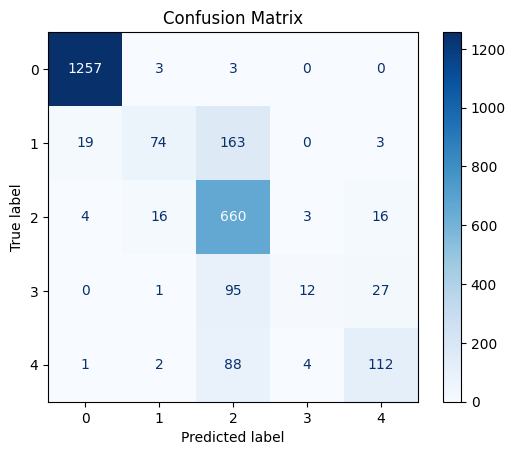

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_train_dataloader,
            device=device)

per class precision: [0.715      0.1        0.63957597 0.75       0.55555556]
per class recall: [0.98426745 0.01111111 0.52161383 0.04       0.42857143]
per class f1_score: [0.82829954 0.02       0.57460317 0.07594937 0.48387097]
average scores >>> precision: 0.552026305457401 | recall: 0.39711276516591354 | f1_score: 0.3965446108648155
accuracy: 0.6897935779816514
QWK:  0.6657688642108317


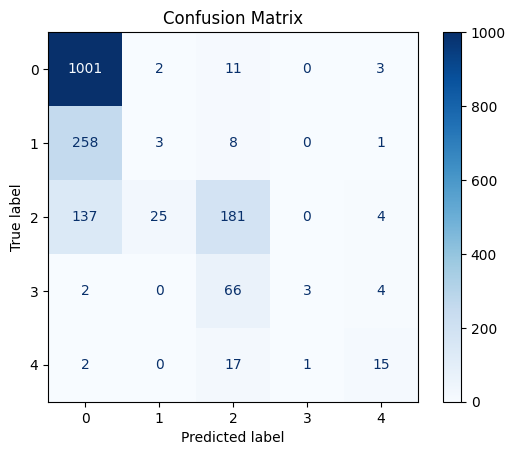

In [ ]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            device=device)

per class precision: [0.77639752 0.32258065 0.52654867 0.         0.61111111]
per class recall: [0.96899225 0.45454545 0.76282051 0.         0.34375   ]
per class f1_score: [0.86206897 0.37735849 0.62303665 0.         0.44      ]
average scores >>> precision: 0.4473275888733447 | recall: 0.5060216430855966 | f1_score: 0.4604928210595878
accuracy: 0.6065934065934065
QWK:  0.7299151815496046


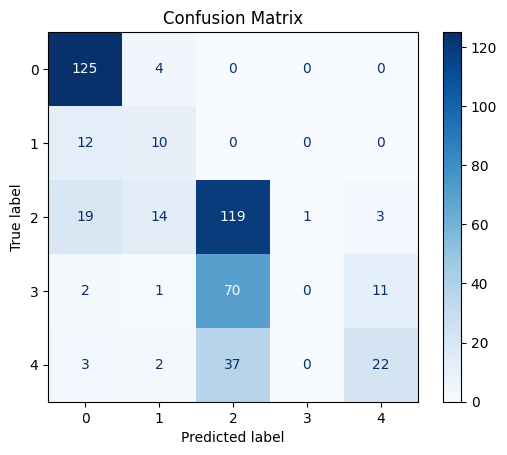

In [ ]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            device=device)

In [ ]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            device=device)

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)